# 1. Setting Up YOLO and Video Processing in Colab

In [4]:
# Install YOLOv5, pytube, and other required libraries
!pip install torch torchvision torchaudio
!pip install ultralytics pytube opencv-python-headless
!pip install yt-dlp
!pip install -U pytube

import torch
import cv2
from pytube import YouTube
import numpy as np
from IPython.display import YouTubeVideo, Video

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.3 MB/s eta 0:00:00


# 2. Using YouTube Video as Input for YOLO Detection

[youtube] Extracting URL: https://www.youtube.com/watch?v=Gr0HpDM8Ki8
[youtube] Gr0HpDM8Ki8: Downloading webpage
[youtube] Gr0HpDM8Ki8: Downloading ios player API JSON
[youtube] Gr0HpDM8Ki8: Downloading mweb player API JSON
[youtube] Gr0HpDM8Ki8: Downloading player 4e23410d
[youtube] Gr0HpDM8Ki8: Downloading m3u8 information
[info] Gr0HpDM8Ki8: Downloading 1 format(s): 18
[download] Destination: input_video.mp4
[download] 100% of    1.24MiB in 00:00:00 at 3.36MiB/s


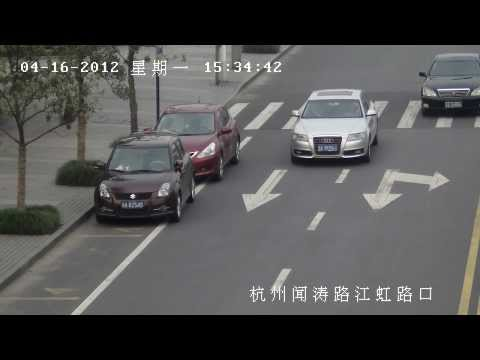

In [5]:
# Download the video with yt-dlp
!yt-dlp -f "best[height<=360]" -o 'input_video.mp4' https://www.youtube.com/watch?v=Gr0HpDM8Ki8

# Display the YouTube video link
YouTubeVideo('Gr0HpDM8Ki8')

# 3. Object Detection with YOLO and Bounding Box Extraction

In [13]:
class ObjectDetection:
    def __init__(self):
        self.model = self.load_model()
        self.classes = self.model.names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Using Device:", self.device)

    def load_model(self):
        # Load YOLOv5 model
        model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        return model

    def score_frame(self, frame):
        self.model.to(self.device)
        frame = [frame]  # YOLOv5 expects input as a list
        results = self.model(frame)
        labels, cord = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
        return labels, cord

    def class_to_label(self, x):
        return self.classes[int(x)]

    def plot_boxes(self, results, frame):
        labels, cord = results
        x_shape, y_shape = frame.shape[1], frame.shape[0]
        for i in range(len(labels)):
            row = cord[i]
            if row[4] >= 0.2:  # Show boxes with confidence >= 0.2
                x1, y1, x2, y2 = int(row[0] * x_shape), int(row[1] * y_shape), int(row[2] * x_shape), int(row[3] * y_shape)
                bgr = (0, 255, 0)
                cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 2)
                cv2.putText(frame, f"{self.class_to_label(labels[i])}: {row[4]:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, bgr, 2)
        return frame

    # Process Video Input and Save Output
    def process_video(self, input_path='input_video.mp4', output_path='output_video.mp4'):
        cap = cv2.VideoCapture(input_path)

        # Define codec, frame rate, and video size for output
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 20
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        if not cap.isOpened():
            print("Error: Cannot open video input.")
            return

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            results = self.score_frame(frame)
            frame = self.plot_boxes(results, frame)

            # Write the frame with bounding boxes to the output file
            out.write(frame)

        cap.release()
        out.release()
        print(f"Detection video saved as '{output_path}'")

# 6. Run the Object Detection and Display Output Video

In [15]:
# Create ObjectDetection instance and process the video
detector = ObjectDetection()
detector.process_video(input_path='input_video.mp4', output_path='output_video.mp4')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-1 Python-3.10.12 torch-2.5.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Using Device: cpu


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

Detection video saved as 'output_video.mp4'


# 7. Display Output Video in Colab

In [17]:
# Verify the File Exists

import os
print("Video exists:", os.path.isfile('output_video.mp4'))

Video exists: True


In [18]:
# Convert the Video to Ensure Compatibility

!ffmpeg -i output_video.mp4 -vcodec libx264 -f mp4 output_converted.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [19]:
# Play the Re-encoded Video: Then, attempt to display the converted file:

from IPython.display import Video
Video('output_converted.mp4', embed=True)